# Final project in Practical Bayes 2025
## Synopsis - Hormonal contraceptives effect on HPV infection
Human papillomavirus (HPV) is a common group of viruses. There are many HPV genotypes, but particular genotypes called "high-risk HPV" have been shown to cause cervical cancer.

HPV is transmitted sexually through skin-to-skin contact. The virus clears itself out in most cases thanks to the immune system. However, persistent infection with high-risk HPV genotypes can cause changes in cells (precancerous conditions) and, if untreated, may lead to cervical cancer. HPV causes also other types of cancers like penile, anal or throat cancer.

The national vaccination program against high-risk HPV started in 2018, and 12-14-year-old boys and girls are now routinely vaccinated in Estonia. However, the HPV vaccine is effective before the initiation of sexual activity and protects only against specific HPV genotypes. Therefore, HPV screening continues to be important in all age groups, but especially in unvaccinated cohorts.

In Estonia, women aged 30-65 are invited to cervical cancer screening programs. It is also known that many people don't attend screening because of different barriers. Therefore, to get a clearer picture of the high risk HPV prevalence and risk factors, we collected population-based data.

This dataset consists of cross-sectional data of 1000 Estonian women aged 30-70 years. Women were invited to a study via mail or e-mail. They filled in a questionnaire (paper or online) and also gave a self-sampling HPV test that was sent to a lab for analysis and genotyping.

Our research question currently is: **Do hormonal contraceptives increase the risk of high-risk HPV infection?**

**Variables:**
* **age**  - age at the time of study (years)
* **first_sex** - age at first intercourse (years)
* **nr_of_sex_partners** - nr of lifetime sexual partners
* **smoking** - current smoking status (1=smoker/0=non-smoker)
* **hormonal_contrcptvs** - ever used hormonal contraception (including birth control pills, hormonal iud, vaginal ring, hormonal implants, hormonal patches or shots) (1=yes/0=no)
* **hc_longest_period** - longest concecutive period of hormonal contraception usage (full years)
* **hrhpv_prevalence** - test result for high-risk HPV (1=positive/0=negative)

In [22]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('hpv_prevalence.csv', index_col=0)
df

,age,first_sex,nr_of_sex_partners,smoking,hormonal_contrcptvs,hc_longest_period,hrhpv_prevalence
0,45,20,6,0,0,0,0
1,68,19,2,1,1,12,0
2,59,21,1,1,0,0,0
3,54,22,1,0,0,0,0
4,36,19,3,0,1,10,0
...,...,...,...,...,...,...,...
995,34,16,10,0,1,17,0
996,67,20,1,0,0,0,0
997,35,18,12,0,1,4,0
998,68,21,2,0,0,0,0


In [23]:
import random
random.seed(10)


# 1. Causal model

**Solution provided by Helene Loorents, Telver Objärtel, Joonas Ariva.**

The goal is to estimate the isolated effect of hormonal contraceptive use on HPV risk. In other words, the goal is to **estimate the causal effect** use of hormonal contraceptives (HC) has on HPV risk.

We have to control for confounders and other variables. We don't want to *overfit* (over control), aka we should only consider *confounders* (causal effect on predictor and outcome) and **not** *mediators* (variable that is on the causal path from predictor to outcome).

## 1.1. DAG
![title](dag.png)

This means the following:
* Exposure: **`hormonal_contrcptvs`** (*HC use*).
* Outcome: **`hrhpv_prevalence`** (*test result*)
* Mediators: `hc_longest_period`. This variable will **not be included** in the model.
* Confounders: `age`, `smoking`, `first_sex` (*age at first sex*), `nr_of_sex_partners`. They will be included in the model.

## 1.2. Outcome likelihood

The outcome of interest is the HPV test result, `hrhpv_prevalence`. The test outcomes are encoded in a binary way (only two possible values):
* `1`, which means the person is HPV positive, and
* `0`, which means the person did not test positive for HPV.

In [24]:
print(f"There are {df.hrhpv_prevalence.sum()} positive test results and {(df.shape[0] - df.hrhpv_prevalence.sum())} negative test results out of {df.shape[0]} total observations.")


There are 113 positive test results and 887 negative test results out of 1000 total observations.


The test results (aka ***the data***) are **generated in a manner** that can be best described with a **Bernoulli distribution**.

In other words, the **likelihood distribution** of the test result follows a Bernoulli distribution, with only one parameter, `p`, the probability of a single HPV test result being *positive*.

$
testresult \sim Bernoulli(p)
$

# 2. Data prepping

Before initiating the analysis, we extract the outcome variable (Y) and the predictor variables (X). As an initial step, we fitted a model without standardizing the predictors; however, the results and diagnostic metrics indicated poor model performance. Therefore, we proceed to standardize selected continuous variables to ensure that the scales of different predictors are comparable and to improve model interpretability and stability.

In [25]:
# Standardize continuous predictors
df["age_z"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["first_sex_z"] = (df["first_sex"] - df["first_sex"].mean()) / df["first_sex"].std()
df["nr_partners_z"] = (df["nr_of_sex_partners"] - df["nr_of_sex_partners"].mean()) / df["nr_of_sex_partners"].std()

# Extract variables
hc = df["hormonal_contrcptvs"].values              # 0/1
age = df["age_z"].values                           # standardized
first_sex = df["first_sex_z"].values               # standardized
nr_of_sex_partners = df["nr_partners_z"].values    # standardized
smoking = df["smoking"].values                     # 0/1
hrhpv_prevalence = df["hrhpv_prevalence"].values   # 0/1

# 3. Fitting the statistical model

We will fit three logistic regression models, each using a different modeling approach. Logistic regression is a type of generalized linear model that relates the outcome of interest to our predictors in a linear combination. The model uses a *logit* link function to project the regression of the predictors to a scale of 0 to 1.



## 3.1. First model

For prior distributions (prior probabilities) of the different predictor variables, we will use **normal distributions**, which are suitable for describing how the values for different predictor variables might arise in a natural human population. For every predictor, lower values are more rare, higher values are also rare. The biggest probability density is between those extreme values - the "average".

Given the priors over our variables, we will fit a logistic regression. Then, we will sample from the posterior distribution using MCMC.

In [26]:
with pm.Model() as hpv_model:
    # Priors for coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_hc = pm.Normal("beta_hc", mu=0, sigma=10)
    beta_age = pm.Normal("beta_age", mu=0, sigma=10)
    beta_firstsex = pm.Normal("beta_firstsex", mu=0, sigma=10)
    beta_partners = pm.Normal("beta_partners", mu=0, sigma=10)
    beta_smoking = pm.Normal("beta_smoking", mu=0, sigma=10)

    # Linear model
    logit_p = (
        alpha +
        beta_hc * hc +
        beta_age * age +
        beta_firstsex * first_sex +
        beta_partners * nr_of_sex_partners +
        beta_smoking * smoking
    )

    # Sigmoid transformation to get probabilities
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=hrhpv_prevalence)

    trace = pm.sample(1000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_hc, beta_age, beta_firstsex, beta_partners, beta_smoking]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


## 3.2. Patsy model

For the second model, we will use Patsy model concepts

In [27]:
import pymc as pm
import patsy
import arviz as az

# ----------------------------------------
# 1. Build the formula using your variable names
# ----------------------------------------
formula = "hrhpv_prevalence ~ 1 + hormonal_contrcptvs + age_z + first_sex_z + nr_partners_z + smoking"

# ----------------------------------------
# 2. Create design matrices using patsy
# ----------------------------------------
y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

predictor_names = X.columns.tolist()
coords = {"predictors": predictor_names}

# ----------------------------------------
# 3. Define the Bayesian model
# ----------------------------------------
with pm.Model(coords=coords) as hpv_patsy_model:

    # Priors on all coefficients (including intercept)
    beta = pm.Normal("beta", mu=0, sigma=1, dims="predictors")

    # Linear predictor
    linear_pred = pm.math.dot(X, beta)

    # Sigmoid link function
    p = pm.Deterministic("p", pm.math.sigmoid(linear_pred))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y.values.ravel())

    # Sampling
    trace_patsy = pm.sample(1000, tune=1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


## 3.3. Bambi model

For the third and final model, we will apply ideas from the Bambi modeling framework.

In [28]:
import bambi as bmb

# Bambi model using logistic regression (binary outcome)
hpv_bambi_model = bmb.Model(
    "hrhpv_prevalence ~ hormonal_contrcptvs + age_z + first_sex_z + nr_partners_z + smoking",
    data=df,
    family="bernoulli"
)

# Sample from the posterior
trace_bambi = hpv_bambi_model.fit(tune=1000, draws=1000, target_accept=0.95)

Modeling the probability that hrhpv_prevalence==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, hormonal_contrcptvs, age_z, first_sex_z, nr_partners_z, smoking]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


# 4. Model diagnostics

After fitting the models, we have to check how well it seems to fit our data.

## 4.1. First model

In [29]:
t_dict = {} #for model comparison later

In [30]:
with hpv_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    pm.compute_log_likelihood(trace, extend_inferencedata=True)

t_dict['hpv_model'] = trace

Sampling: [y_obs]


Output()

Output()

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha         -2.236  0.176  -2.558   -1.897      0.004    0.003    2329.0   
beta_hc        0.058  0.231  -0.367    0.503      0.005    0.003    2471.0   
beta_age       0.040  0.147  -0.224    0.313      0.003    0.002    3338.0   
beta_firstsex -0.334  0.129  -0.578   -0.098      0.002    0.002    3937.0   
beta_partners  0.072  0.136  -0.173    0.332      0.002    0.002    3596.0   
...              ...    ...     ...      ...        ...      ...       ...   
p[995]         0.194  0.037   0.131    0.269      0.001    0.000    4678.0   
p[996]         0.100  0.021   0.063    0.138      0.000    0.000    4714.0   
p[997]         0.160  0.038   0.093    0.233      0.001    0.000    4090.0   
p[998]         0.089  0.017   0.059    0.123      0.000    0.000    4925.0   
p[999]         0.140  0.021   0.103    0.182      0.000    0.000    4040.0   

               ess_tail  r_hat  
alpha            2882.0    1.0

array([[<Axes: title={'center': 'beta_hc'}>,
        <Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_firstsex'}>],
       [<Axes: title={'center': 'beta_partners'}>,
        <Axes: title={'center': 'beta_smoking'}>, <Axes: >]], dtype=object)

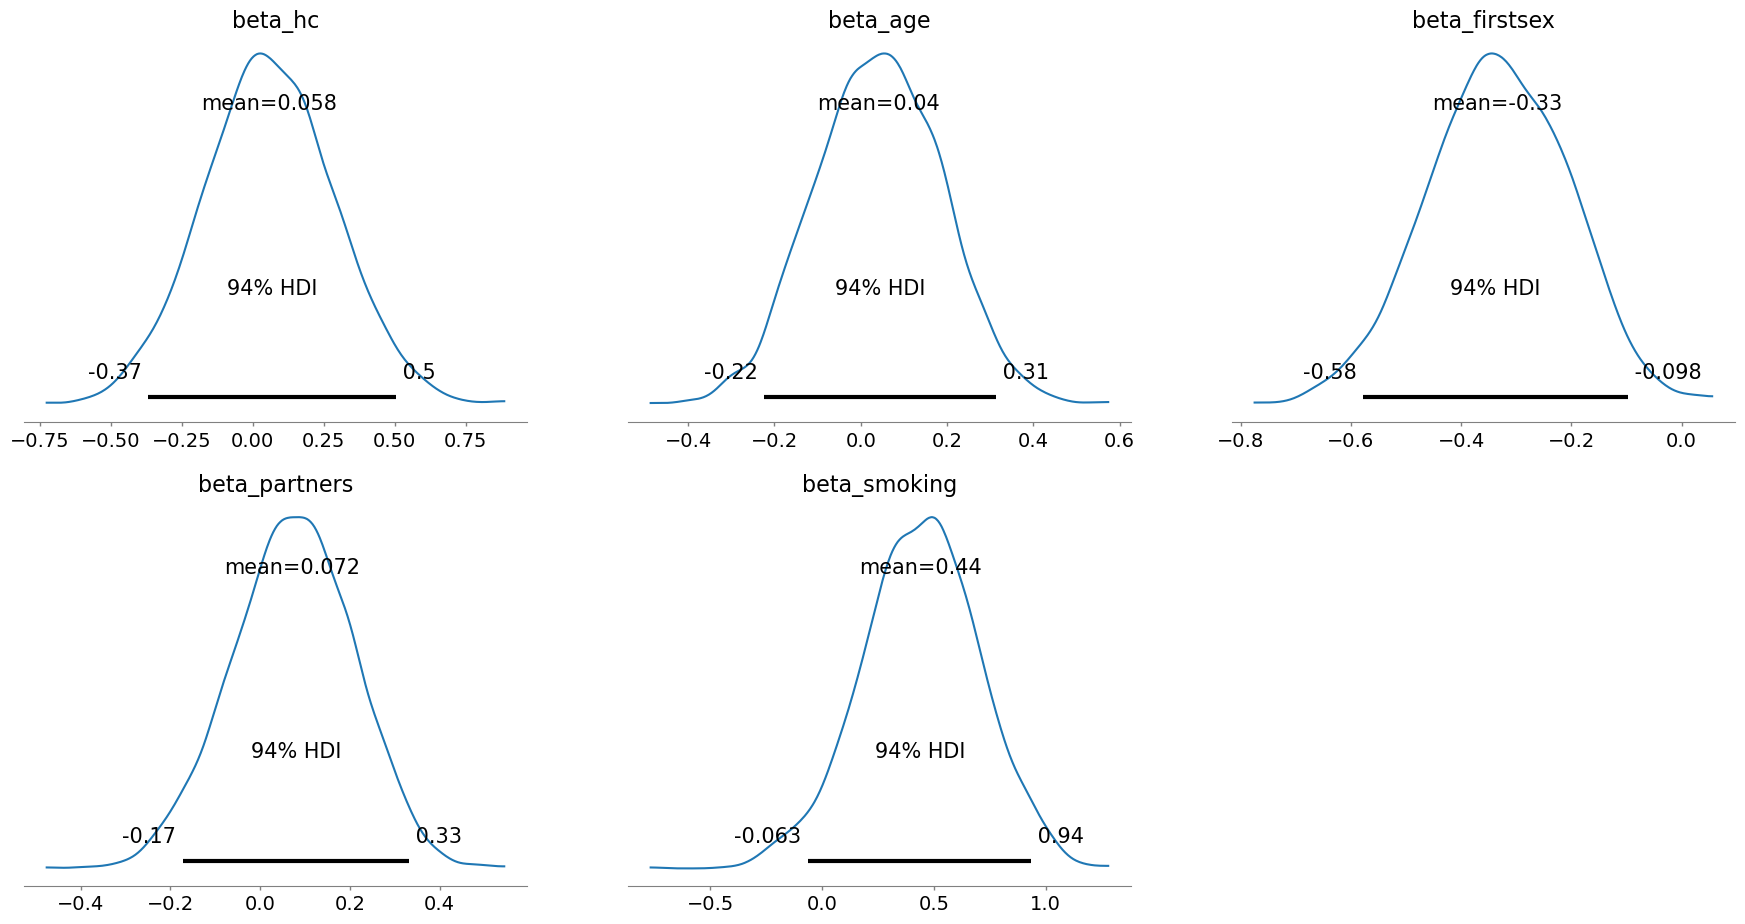

In [31]:
print(pm.summary(trace))
pm.plot_posterior(trace, var_names=["beta_hc", "beta_age", "beta_firstsex", "beta_partners", "beta_smoking"])

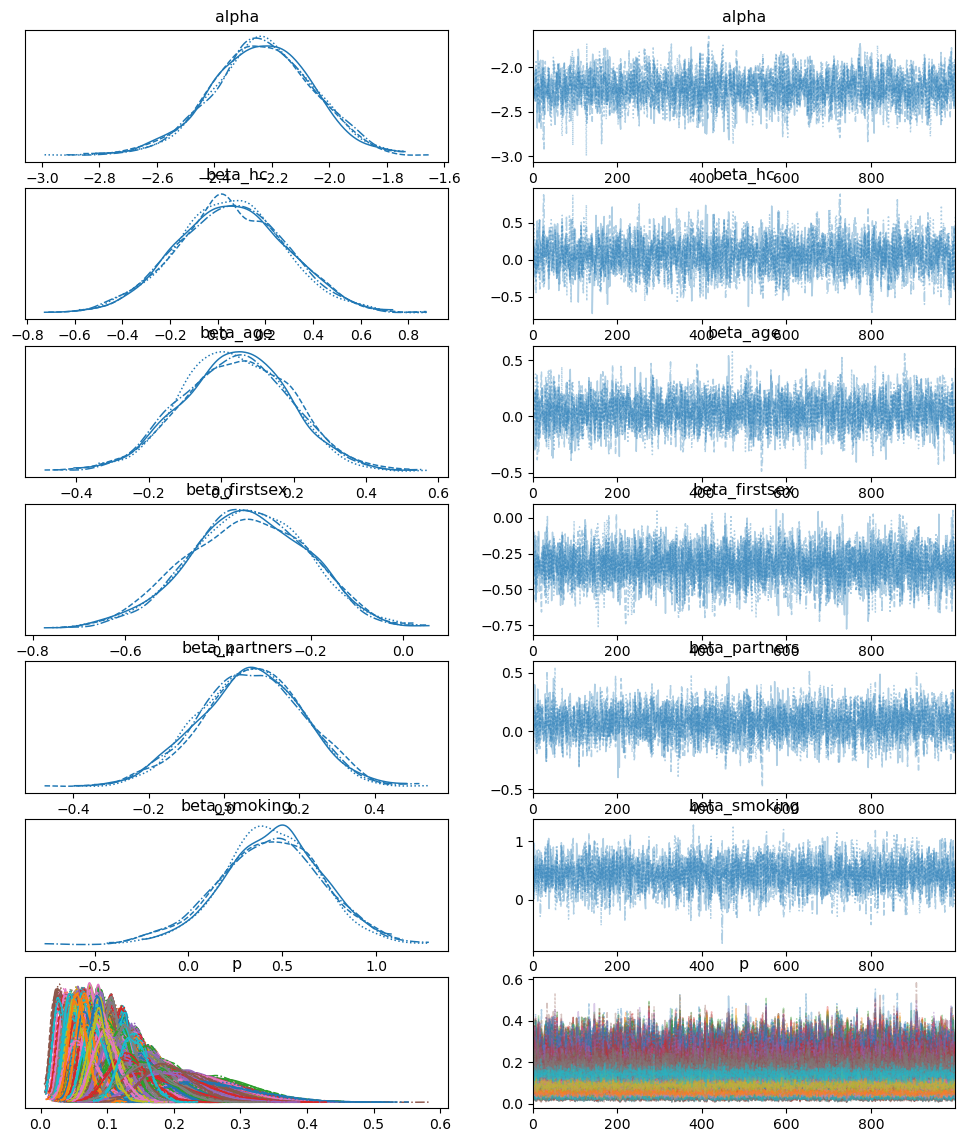

In [32]:
pm.plot_trace(trace)
plt.show()

## 4.2. Patsy model

In [33]:
with hpv_patsy_model:
    pm.sample_posterior_predictive(trace_patsy, extend_inferencedata=True)
    pm.compute_log_likelihood(trace_patsy, extend_inferencedata=True)

t_dict['hpv_model_patsy'] = trace_patsy

Sampling: [y_obs]


Output()

Output()

In [34]:
print(pm.summary(trace_patsy))

                            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[Intercept]           -2.168  0.171  -2.471   -1.825      0.003    0.002   
beta[hormonal_contrcptvs]  0.000  0.225  -0.408    0.427      0.004    0.003   
beta[age_z]                0.025  0.144  -0.244    0.295      0.002    0.002   
beta[first_sex_z]         -0.321  0.126  -0.557   -0.084      0.002    0.001   
beta[nr_partners_z]        0.076  0.136  -0.193    0.315      0.002    0.002   
...                          ...    ...     ...      ...        ...      ...   
p[995]                     0.196  0.037   0.132    0.267      0.001    0.000   
p[996]                     0.103  0.021   0.068    0.144      0.000    0.000   
p[997]                     0.164  0.039   0.092    0.233      0.001    0.000   
p[998]                     0.093  0.017   0.061    0.125      0.000    0.000   
p[999]                     0.140  0.020   0.104    0.179      0.000    0.000   

                           ess_bulk  es

array([[<Axes: title={'center': 'beta\nIntercept'}>,
        <Axes: title={'center': 'beta\nhormonal_contrcptvs'}>,
        <Axes: title={'center': 'beta\nage_z'}>],
       [<Axes: title={'center': 'beta\nfirst_sex_z'}>,
        <Axes: title={'center': 'beta\nnr_partners_z'}>,
        <Axes: title={'center': 'beta\nsmoking'}>]], dtype=object)

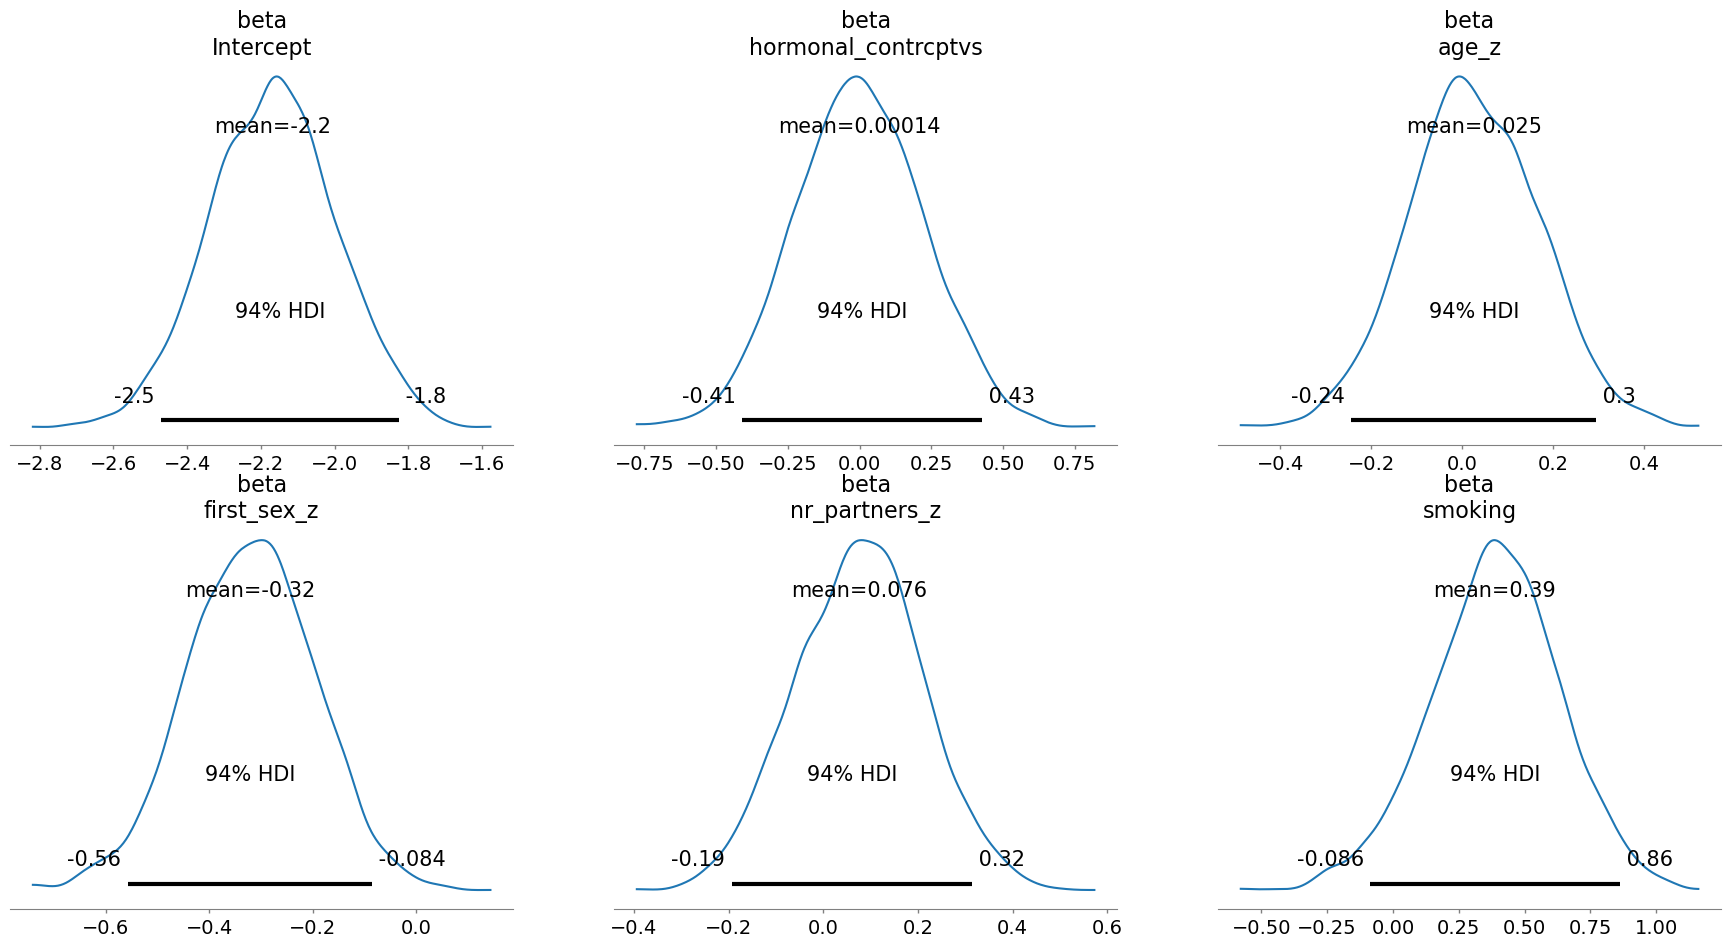

In [35]:
pm.plot_posterior(trace_patsy, var_names=["beta"])

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

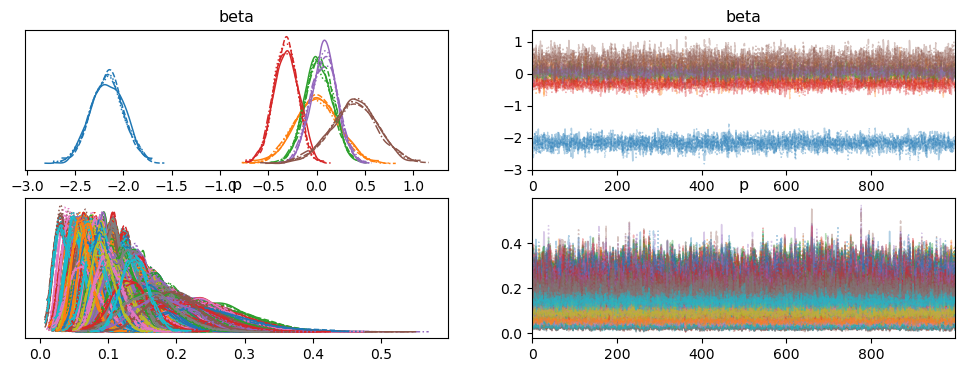

In [36]:
pm.plot_trace(trace_patsy)

## 4.3. Bambi model

In [37]:
pymc_model = hpv_bambi_model.backend.model

idata_bambi = trace_bambi  
idata_bambi.extend(pm.sample_posterior_predictive(trace_bambi, model=pymc_model, extend_inferencedata=True))
idata_bambi.extend(pm.compute_log_likelihood(trace_bambi, model=pymc_model, extend_inferencedata=True))

t_dict["hpv_model_bambi"] = idata_bambi

Sampling: [hrhpv_prevalence]


Output()

ERROR! Session/line number was not unique in database. History logging moved to new session 3


Output()

In [38]:
az.summary(idata_bambi)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.228,0.168,-2.539,-1.916,0.003,0.002,3261.0,2723.0,1.0
hormonal_contrcptvs,0.066,0.226,-0.358,0.493,0.004,0.004,2730.0,2397.0,1.0
age_z,0.038,0.146,-0.239,0.313,0.003,0.002,2895.0,2464.0,1.0
first_sex_z,-0.325,0.128,-0.559,-0.079,0.002,0.002,3021.0,2404.0,1.0
nr_partners_z,0.071,0.139,-0.208,0.311,0.003,0.002,2970.0,3107.0,1.0
smoking,0.432,0.255,-0.042,0.899,0.004,0.003,4293.0,2931.0,1.0


In [39]:
hpv_bambi_model.build()
hpv_bambi_model.backend.model

          Intercept ~ Normal(0, 1.5)
hormonal_contrcptvs ~ Normal(0, 2.01)
              age_z ~ Normal(0, 1)
        first_sex_z ~ Normal(0, 1)
      nr_partners_z ~ Normal(0, 1)
            smoking ~ Normal(0, 2.91)
                  p ~ Deterministic(f(smoking, nr_partners_z, first_sex_z, age_z, hormonal_contrcptvs, Intercept))
   hrhpv_prevalence ~ Bernoulli(p)

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'hormonal_contrcptvs'}>,
        <Axes: title={'center': 'hormonal_contrcptvs'}>],
       [<Axes: title={'center': 'age_z'}>,
        <Axes: title={'center': 'age_z'}>],
       [<Axes: title={'center': 'first_sex_z'}>,
        <Axes: title={'center': 'first_sex_z'}>],
       [<Axes: title={'center': 'nr_partners_z'}>,
        <Axes: title={'center': 'nr_partners_z'}>],
       [<Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'smoking'}>]], dtype=object)

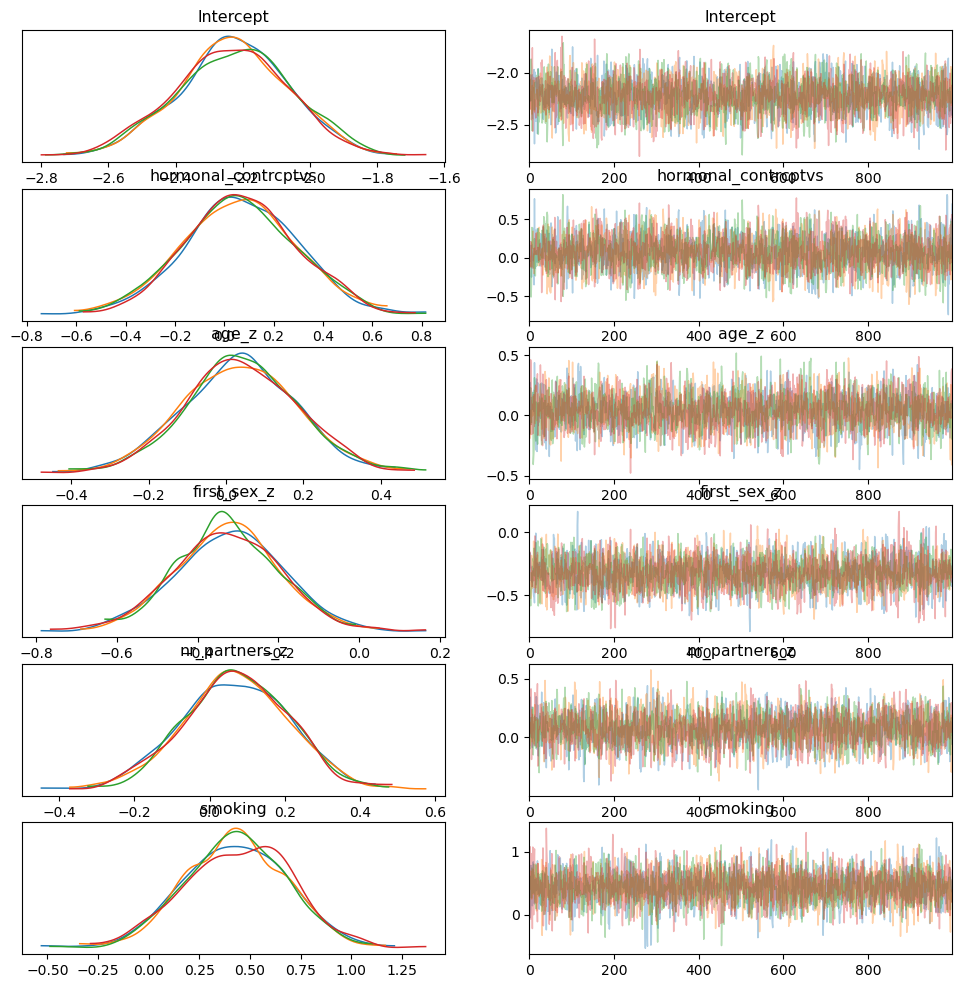

In [40]:
az.plot_trace(trace_bambi, compact=False)

## 4.4. Model comparison

All models exhibited good diagnostic plots and had $rhat = 1$, indicating convergence, so we will compare them to determine which is the most useful.

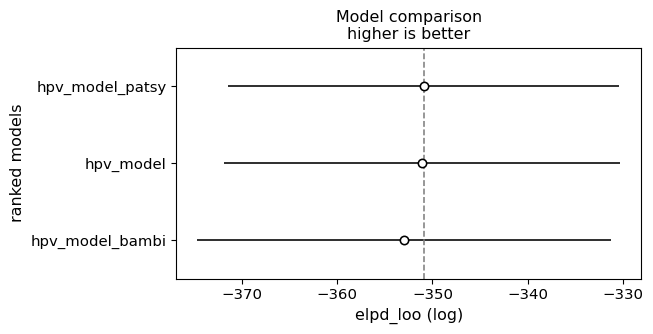

In [41]:
comp = az.compare(t_dict)
az.plot_compare(comp)
plt.show()

# 5. Results

In [42]:
for name, idata in t_dict.items():
    summary_df = az.summary(idata, round_to=2)
    second_row = summary_df.iloc[1]  
    print(f"\nModel: {name} — Variable: {summary_df.index[1]}")
    print(second_row)


Model: hpv_model — Variable: beta_hc
mean            0.06
sd              0.23
hdi_3%         -0.37
hdi_97%         0.50
mcse_mean       0.00
mcse_sd         0.00
ess_bulk     2471.21
ess_tail     2441.83
r_hat           1.00
Name: beta_hc, dtype: float64

Model: hpv_model_patsy — Variable: beta[hormonal_contrcptvs]
mean            0.00
sd              0.23
hdi_3%         -0.41
hdi_97%         0.43
mcse_mean       0.00
mcse_sd         0.00
ess_bulk     3079.15
ess_tail     2919.33
r_hat           1.00
Name: beta[hormonal_contrcptvs], dtype: float64

Model: hpv_model_bambi — Variable: hormonal_contrcptvs
mean            0.07
sd              0.23
hdi_3%         -0.36
hdi_97%         0.49
mcse_mean       0.00
mcse_sd         0.00
ess_bulk     2729.93
ess_tail     2396.75
r_hat           1.00
Name: hormonal_contrcptvs, dtype: float64


# 6. Conclusions

We investigated whether the use of hormonal contraceptives is associated with an increased risk of high-risk HPV infection. To do this, we fit three different logistic regression models, each using a distinct modeling approach. All models showed good convergence diagnostics (e.g., $\hat{R} = 1$) and produced similar results in terms of predictive performance.

As shown in the model comparison plot, the estimated expected log predictive densities (elpd_loo) for the models largely overlap, with the hpv_model_patsy showing a slightly higher mean elpd_loo. This suggests that no model clearly outperforms the others.

From the models, we obtained posterior distributions for the possible causal effect of hormonal contraceptive use on HPV risk. Since the credible intervals for these estimates include zero (indicating no causal effect), and the intervals are reasonably symmetric, we conclude that hormonal contraceptives do not increase the risk of high-risk HPV infection.

However, it is important to note that different modeling assumptions or prior distributions could lead to different conclusions. Based on our DAG and the assumptions made in our analysis, we find no strong evidence of a meaningful causal effect